# Boosting

We will look here into the practicalities of boosted trees. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/conda/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Dataset

First, the data. We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [2]:
elect_df = pd.read_csv("data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtraindf, Xtestdf, ytrain, ytest = train_test_split(X,response,test_size=0.2, random_state=1983)


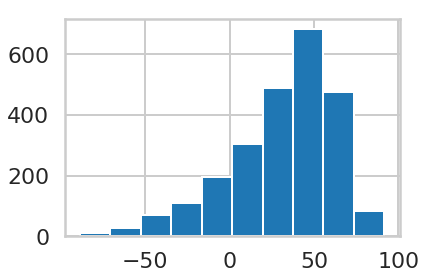

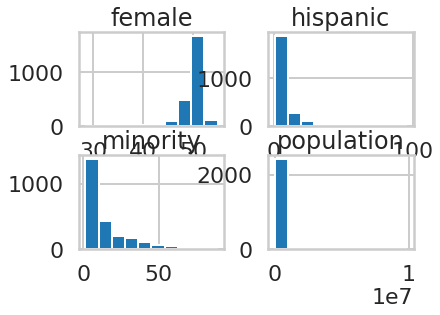

In [5]:
plt.hist(ytrain)
Xtraindf.hist(column=['minority', 'population','hispanic','female']);

How would you describe these variables?

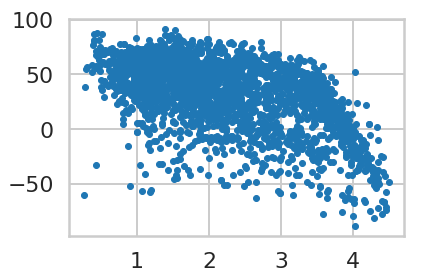

In [6]:
x = Xtraindf['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values
y = y[o]
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)

## Boosting Regression Trees

 Gradient Bossting is very state of the art, and has major connections to logistic regression, gradient descent in a functional space, and search in information space. See Schapire and Freund's MIT Press book for details (Google is a wonderful thing).

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak 'learners' (aka, models) which are fit sequentially. The first one fits the signal, the second one the first model's residual, the third the second model's residual, and so on. At each stage we upweight the places that our previous model did badly on. First let us illustrate.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


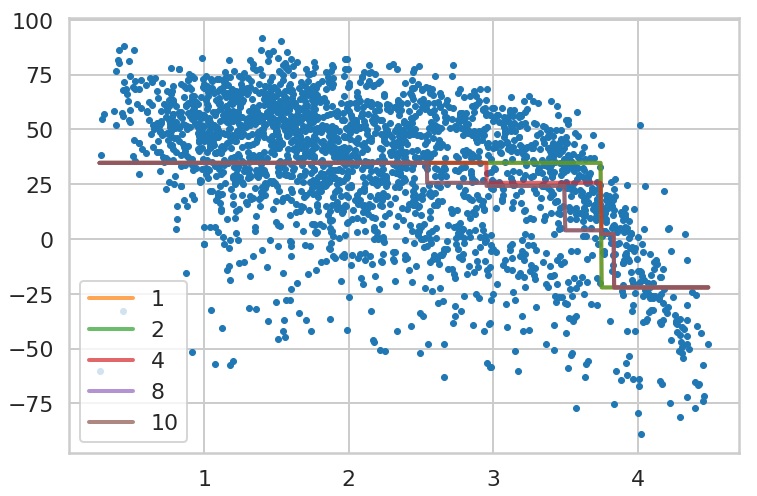

In [8]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
plt.figure(figsize=(12, 8))
plt.plot(xx, y, '.');
counter = 0
estab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1),
                          n_estimators=500, learning_rate=1)
estab.fit(xx, y)
staged_predict_generator = estab.staged_predict(xx)
for stagepred in staged_predict_generator:
    counter = counter + 1
    if counter in [1, 2, 4, 8, 10, 50, 100, 200]:
        plt.plot(xx, stagepred, alpha=0.7, label=str(counter), lw=4)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(2)

## Now on the whole data set

0.8212036130421078
0.7268187754764799


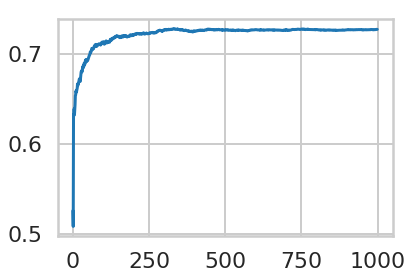

In [11]:
estab2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                          n_estimators=1000, learning_rate=0.3)
estab2.fit(Xtraindf, ytrain)
print(estab2.score(Xtraindf, ytrain))
print(estab2.score(Xtestdf, ytest))

staged_scores = estab2.staged_score(Xtestdf, ytest)
i=1
scores=[]
for stagesc in staged_scores:
    scores=np.append(scores,stagesc)
    i = i+1
plt.plot(scores);

Ok, so this demonstration helps us understand some things about boosting.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` or decrease `max_depth` to reduce variance and increase the bias.

EXERCISE

1. What do you expect to happen if you increase `max_depth` to 5?  Edit the code above to explore the result.
2. What do you expect to happen if you put `max_depth` back to 1 and decrease the `learning_rate` to 0.1?  Edit the code above to explore the result.
3. Do a little work to find some sort of 'best' values of `max_depth` and `learning_rate`.  Does this result make sense?

**Answers**
1. Increasing `max_depth` for each model does not really improve things.  It will make each model more complex, which may not be a good thing.  We want lots of little models that each are not overfit, so allowing any single model to have a lot of complexity (and thus overfit) could be a problem.
2. The model will progress much more slowly to fitting to the data well.  This may be a good thing: this is essentially a form of 'regularization' in each model and will help prevent overfitting to any one model.  It allows future models to have more 'error' to be able to explain.
3. See code below.


In [15]:
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV

param_dict3 = OrderedDict(
    base_estimator__max_depth = [8,10,12,14],
    learning_rate = [0.2, 0.4, 0.6, 0.8], 
)

# your code here
gs= GridSearchCV(AdaBoostRegressor(n_estimators=3000,base_estimator=DecisionTreeRegressor(max_features=sqrt(n_features))),param_dict3,cv=4,n_jobs=-1)



In [16]:
gs.fit(Xtraindf,ytrain)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=200,
         random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=OrderedDict([('base_estimator__max_depth', [1, 3, 5, 10]), ('learning_rate', [0.2, 0.4, 0.6, 0.8])]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gs.best_params_

{'base_estimator__max_depth': 10, 'learning_rate': 0.6}

### Deviance

A deviance plot can be used to compare train and test errors against the number of iterations.

Training error (deviance, related to the KL-divergence) is stored in est.train_score_
Test error is computed using est.staged_predict (this uses est.loss_)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(-80, 100)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (12, 8))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    #ax.set_ylim(ylim)
    return test_dev, ax

0.9182034834352985


0.7584049191556478

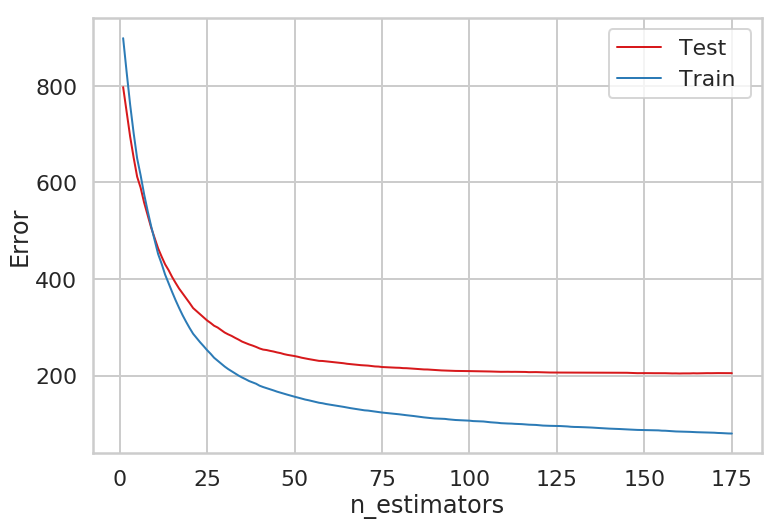

In [109]:
#gb = GradientBoostingRegressor(n_estimators=250, max_depth=2,learning_rate=0.2,max_features=6)
#gb = GradientBoostingRegressor(n_estimators=200, max_depth=3,learning_rate=0.1,max_features=6) 0.755
#gb = GradientBoostingRegressor(n_estimators=1000, max_depth=3,learning_rate=0.06,max_features=6) #0.757
#gb= GradientBoostingRegressor(n_estimators=200, max_depth=4,learning_rate=0.07,max_features=5) #0.7633990243124175
#gb= GradientBoostingRegressor(n_estimators=150, max_depth=5,learning_rate=0.065,max_features=5) #0.7650
gb= GradientBoostingRegressor(n_estimators=175, max_depth=5,learning_rate=0.065,max_features=4) #0.766
gb.fit(Xtraindf, ytrain)
deviance_plot(gb, Xtestdf, ytest, ylim=(0,0.8));
plt.legend();
print(gb.score(Xtraindf,ytrain))
gb.score(Xtestdf,ytest)

## Notice the wide gap. This is an indication of overfitting!

Unlike random forests, where we are using the randomness to our benefits, the GBRT requires careful cross-validation

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!)

Hyperparameter tuning I usually follow this recipe to tune the hyperparameters:

- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed
- This last point is a tradeof between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate max_depth. And min_samples_per_leaf is not independent either, so if you do use cross-val, you might just use one of those.

EXERCISE: use a param grid and `GridSearchCV` to try and overfit this model as little as possible. We'll only explore part of the space as this takes time.

eg:

```
param_grid = {'learning_rate': [0.1, 0.01],
              'min_samples_leaf': [3, 5],  ## depends on the num of training examples, or use max_depth
              'max_features': [0.2, 0.6]
              }
```

And remember you;ll have to figure the number of trees

In [104]:
# your code here
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from math import sqrt
param_dict3 = OrderedDict(
    learning_rate = [0.065],
    max_features = [5],
    max_depth=[5],
    n_estimators = [150,125,175]
)

# your code here
gs= GridSearchCV(GradientBoostingRegressor(),param_dict3,cv=4,n_jobs=-1)
gs.fit(Xtraindf,ytrain)
gs.best_params_

{'learning_rate': 0.065,
 'max_depth': 5,
 'max_features': 5,
 'n_estimators': 175}

Once you find the best model, make a deviance plot with the best params.

In [ ]:
# your code here

Also find the most informative features

### Note: what's the relationship between residuals and the gradient?

Pavlos showed in class that for the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is a more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.

---